In [89]:
import pandas as pd
import numpy as np
import missingno

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split

# catboost
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv

# shap
import shap


# from imblearn.pipeline import make_pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

sns.set()

SEED = 2

pd.set_option('display.max_columns', 500)

In [90]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [91]:
target = 'price'

In [92]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9901706,Cute big one bedroom,1904415,Natalie,Manhattan,Upper West Side,40.77789,-73.97701,Entire home/apt,180,1,0,NaN,NaN,1,0
1,299531,Feel like you never leave your home,1220404,Tom,Brooklyn,East New York,40.66795,-73.89232,Entire home/apt,100,1,119,2019-06-30,1.39,2,289
2,2461439,Pristine Lower East Side Sanctuary,12586492,Sausan,Manhattan,Lower East Side,40.72007,-73.98946,Entire home/apt,133,14,177,2019-05-03,2.82,2,221
3,127387,"Luxe, Spacious 2BR 2BA Nr Trains",23276,Katharine,Brooklyn,Gowanus,40.66862,-73.99260,Entire home/apt,260,30,3,2014-08-04,0.03,1,316
4,629315,1BD brownstone apt in Fort Greene!,2397437,Lauren,Brooklyn,Fort Greene,40.68935,-73.96950,Entire home/apt,120,3,22,2015-10-28,0.27,1,189


In [93]:
# look at the dataset
# focus on nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34217 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34212 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     

<AxesSubplot:>

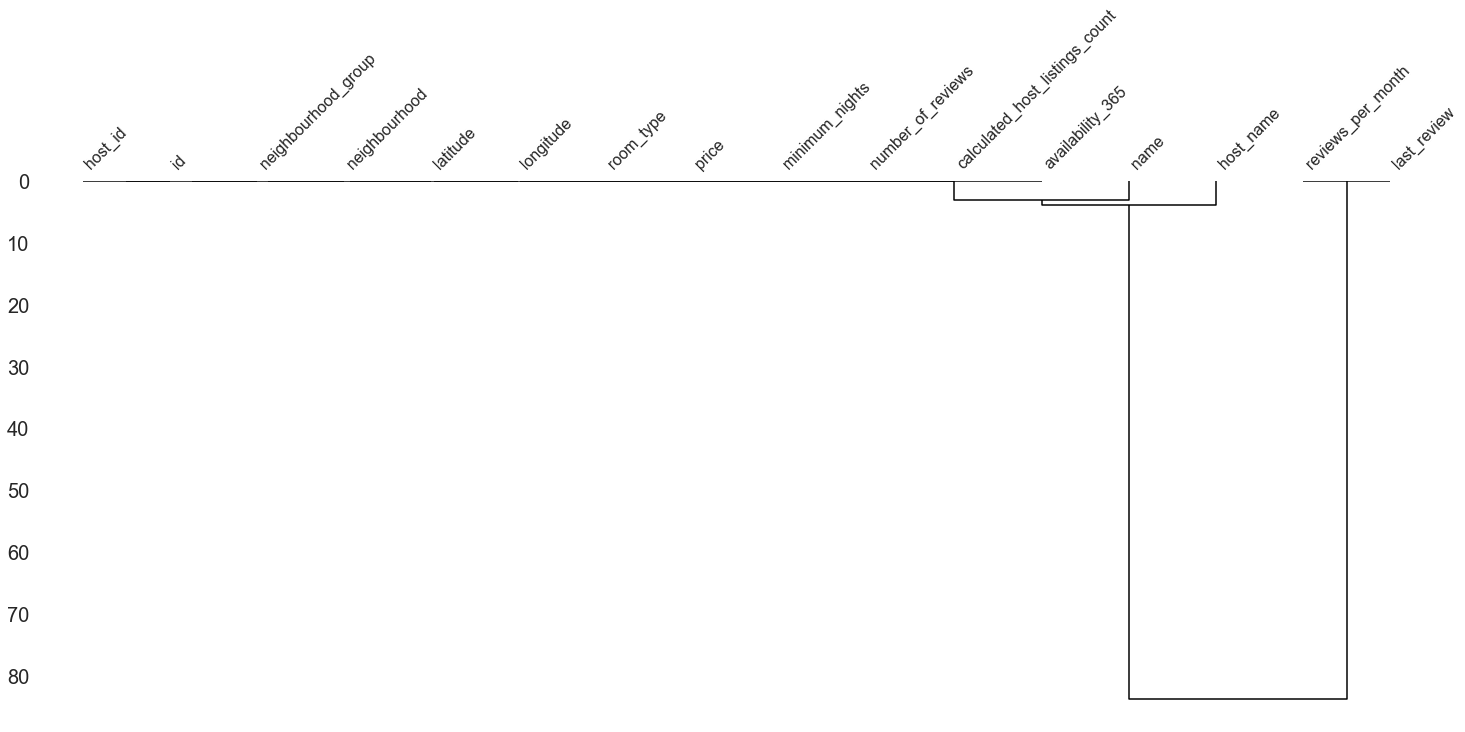

In [94]:
missingno.dendrogram(df)

<AxesSubplot:>

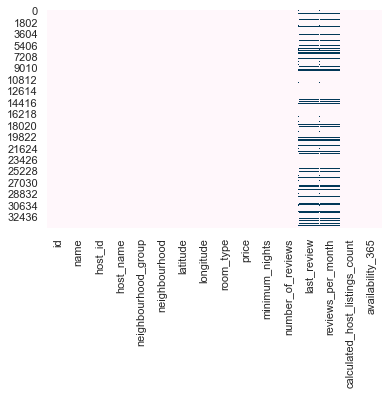

In [95]:
# missing data
# let's look at them more closely: evaporation & sunshine have a ton missing
# code modified from https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')

In [96]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [97]:
df.select_dtypes(include=['object']).columns.tolist()

['name',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review']

In [130]:
def clean_train(df):
    df = (df.pipe(impute)
            .pipe(label_encoder)
            .pipe(mice_impute)
            .pipe(string_to_datetime, 'last_review')
            #.pipe(data_types)
            #.pipe(drop_cols)
         )
    
    return df

def clean_test(df):
    
    "the only difference is that data_types & mice_impute_test do not have the target"
    
    df = (df.pipe(impute)
            .pipe(label_encoder)
            .pipe(mice_impute_test)
            .pipe(string_to_datetime, 'last_review')
            #.pipe(data_types)
            #.pipe(drop_cols)
         )
    
    return df


# def drop_cols(df):
#     # these two cols have very high missing data
#     cols = ['evaporation', 'sunshine']
#     df = df.drop(columns=cols)
    
#     return df


# there's time series data
def string_to_datetime(df, var):
    """
    Converts string representation of date into datetime.
    Splits datetime into separate columns.
    
    Only going to use this on filename for easier indexing.
    """
    df = df.copy()
    
    df['time'] = pd.to_datetime(df[var])
   
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    
    df = df.drop(columns=['time', var])

    return df

# def data_types(df):
#     # change dtypes from object to numeric
#     cols = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed', 
#             'wind_speed9am', 'wind_speed3pm', 'humidity9am',
#             'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 
#             'cloud3pm','temp9am', 'temp3pm', 'rain_today', 'rain_tomorrow']
    
#     df[cols] = df[cols].apply(pd.to_numeric)
  
#     return df

# def data_types_test(df):
#     # change dtypes from object to numeric
#     cols = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed', 
#             'wind_speed9am', 'wind_speed3pm', 'humidity9am',
#             'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 
#             'cloud3pm','temp9am', 'temp3pm', 'rain_today']
    
#     df[cols] = df[cols].apply(pd.to_numeric)
  
#     return df


def impute(df):
    """
    impute categorial variables with mode
    """
    # look at cat vars to include
    cat_vars = df.select_dtypes(include=['object']).columns.tolist()
    
    for var in cat_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
        
    return df


def label_encoder(df):
    #### Label Encoder
    
    # I'm pretty sure the label encoder is unnecessary here bc of catboost handling categoricals automatically
    # but using it to help inpute missing data
    
    # converts categorical data into numbers
    # convert the same category to a number with the same value
    # labels are ordered randomly (in the existing order of the data)
    # becomes ordinal (which might not be good)
    # code from: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models

    # look at cat vars to include
    # print(df.select_dtypes(include=['object']).columns.tolist())

    # LabelEncoder() accepts an array
    # to encode in a column:
    # 1. label_enc = LabelEncoder()
    # 2. df[col] = label_enc.fit_transform(df[col])

    lencoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        # initialize class with key-value pair in dict
        lencoders[col] = LabelEncoder()
        # fit_transform
        df[col] = lencoders[col].fit_transform(df[col])

    return df

def mice_impute(df):
    
    # MICE: Multiple Imputation by Chained Equations
    # code: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
    # what is MICE? https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained
    # scikit-learn: A strategy for imputing missing values by modeling each feature with missing values 
    # as a function of other features in a round-robin fashion.

    df = df.copy(deep=True) 
    mice_imputer = IterativeImputer()
    df.iloc[:, :] = mice_imputer.fit_transform(df)

    # this converts all values to floats. catboost cannot handle floats for categorical vars
    # convert the cat variables to int
    cat_features = ['name',
                    'host_name',
                    'neighbourhood_group',
                    'neighbourhood',
                    'room_type',
                    'last_review']

    df[cat_features] = df[cat_features].astype(int)
    
    return df

def mice_impute_test(df):
    
    # MICE: Multiple Imputation by Chained Equations
    # code: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
    # what is MICE? https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained
    # scikit-learn: A strategy for imputing missing values by modeling each feature with missing values 
    # as a function of other features in a round-robin fashion.

    df = df.copy(deep=True) 
    mice_imputer = IterativeImputer()
    df.iloc[:, :] = mice_imputer.fit_transform(df)

    # this converts all values to floats. catboost cannot handle floats for categorical vars
    # convert the cat variables to int
    cat_features = ['name',
                    'host_name',
                    'neighbourhood_group',
                    'neighbourhood',
                    'room_type',
                    'last_review']

    df[cat_features] = df[cat_features].astype(int)
    
    return df

In [99]:
# let's just look at years
df = clean_train(df)

In [100]:
# Table of features with missing data 
# code modified from https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
# most are < 50% missing
# drop evaporation & sunshine
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing.head(20)

,Total,Percent Missing
id,0,0.0
name,0,0.0
month,0,0.0
day,0,0.0
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0


In [101]:
# double-check for NaNs (there shouldn't be any)
print(df.isna().sum().sum())

0


In [102]:
df.dtypes

id                                float64
name                                int64
host_id                           float64
host_name                           int64
neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                             float64
minimum_nights                    float64
number_of_reviews                 float64
reviews_per_month                 float64
calculated_host_listings_count    float64
availability_365                  float64
day                                 int64
month                               int64
year                                int64
dtype: object

In [103]:
df.month.value_counts()

1    34226
Name: month, dtype: int64

In [104]:
# # train/val split: val on 2016, 2017
# train = df[df['year'] < 2016]
# val = df[df['year'] > 2015]

# train.shape, val.shape

In [105]:
X = df.drop(columns=target)
y = df[target]

In [106]:
X = df.drop(columns=target)
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(22931, 17) (11295, 17) (22931,) (11295,)


In [107]:
# # Arrange data into X features matrix and y target vector 
# X_train = train.drop(columns=target)
# y_train = train[target]
# X_val = val.drop(columns=target)
# y_val = val[target]

# # keep entire df
# X = df.drop(columns=target)
# y = df[target]

In [108]:
### Build Model

In [109]:
#### get list for cat_features
# X_train.columns drops 'rain_tomorrow'
cat_features_names = ['name',
                    'host_name',
                    'neighbourhood_group',
                    'neighbourhood',
                    'room_type',
                    'day', 
                    'month',
                    'year']

# we need a list of the cols
cat_features = [X_train.columns.get_loc(col) for col in cat_features_names]
cat_features

[1, 3, 4, 5, 8, 14, 15, 16]

In [127]:
# get model's validation accuracy
# fit on train, score on val
model = CatBoostRegressor(iterations=15,
                           depth=2,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=True,
                           cat_features=cat_features,
                           random_seed=SEED
)


model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
)
print('Validation Accuracy: ', model.score(X_val, y_val))

0:	learn: 221.5059479	test: 228.3952595	best: 228.3952595 (0)	total: 7.83ms	remaining: 110ms
1:	learn: 219.3850145	test: 227.1595548	best: 227.1595548 (1)	total: 10.5ms	remaining: 68.2ms
2:	learn: 218.0367595	test: 225.4964655	best: 225.4964655 (2)	total: 16.2ms	remaining: 64.7ms
3:	learn: 217.4597642	test: 225.0737757	best: 225.0737757 (3)	total: 22ms	remaining: 60.5ms
4:	learn: 217.0025945	test: 224.3468334	best: 224.3468334 (4)	total: 24.2ms	remaining: 48.4ms
5:	learn: 216.7989182	test: 224.2493375	best: 224.2493375 (5)	total: 26.7ms	remaining: 40ms
6:	learn: 216.3612756	test: 224.3978052	best: 224.2493375 (5)	total: 28.8ms	remaining: 33ms
7:	learn: 216.3004669	test: 224.4425778	best: 224.2493375 (5)	total: 30.8ms	remaining: 27ms
8:	learn: 216.1529441	test: 224.3531041	best: 224.2493375 (5)	total: 32.7ms	remaining: 21.8ms
9:	learn: 215.8487432	test: 223.8711993	best: 223.8711993 (9)	total: 34.8ms	remaining: 17.4ms
10:	learn: 215.6903642	test: 223.6621787	best: 223.6621787 (10)	total

In [132]:
predictions = model.predict(clean_test(test))

In [133]:
predictions

array([206.95197574, 129.01639331,  52.92828255, ..., 215.71378363,
       141.5070317 , 309.85296739])

In [111]:
# feature importances
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,room_type,35.749337
1,neighbourhood,17.425997
2,availability_365,12.000513
3,reviews_per_month,10.264901
4,calculated_host_listings_count,8.178877
5,neighbourhood_group,4.092211
6,minimum_nights,3.264151
7,number_of_reviews,2.868685
8,id,2.426574
9,latitude,2.124984


In [112]:
shap_values = model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(22931, 17)


In [113]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_train.iloc[3,:])

In [114]:
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X_train.iloc[91,:])

(22931, 17) (22931, 17)


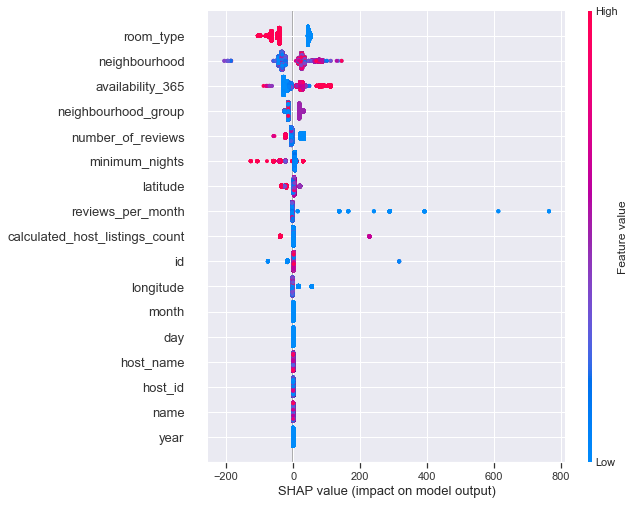

In [115]:
# hmm not sure what's going on here
print(shap_values.shape, X_train.shape)
shap.summary_plot(shap_values, X_train)

In [116]:
X_small = X_train.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

In [117]:
# cv modified from https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

model = CatBoostRegressor(iterations=15,
                           depth=2,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=True,
                           cat_features=cat_features,
                           random_seed=SEED
)

params = {'iterations': 80, 
          'loss_function': 'RMSE',
          # 'custom_loss': 'AUC', THIS IS INCORRECT, THROWS ERROR
          'learning_rate': 0.5
}

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
    seed=SEED
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [118]:
cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,236.891575,24.915040,237.248539,6.736805
1,1,224.353839,25.935034,223.315143,7.145722
2,2,220.023233,26.637339,217.969312,7.356269
3,3,218.040915,26.521720,214.924306,7.399761
4,4,216.893602,27.085592,212.590304,7.230037


In [119]:
best_value = np.min(cv_data['test-RMSE-mean'])
best_iter = np.argmin(cv_data['test-RMSE-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-RMSE-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 209.9596±28.7851 on step 66


In [121]:
# print(cv_data.get_params())

In [125]:
# Training the model after parameter tunning

best_model = CatBoostRegressor(
    random_seed=SEED,
    iterations=int(cv_data.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

AttributeError: 'DataFrame' object has no attribute 'tree_count_'

In [879]:
# train on entire dataset
X_train = df.drop(columns=target)
y_train = df[target]

model.fit(X_train,
          y_train)

0:	learn: 0.4127370	total: 12.9ms	remaining: 181ms
1:	learn: 0.3938051	total: 22.5ms	remaining: 146ms
2:	learn: 0.3778922	total: 33.1ms	remaining: 132ms
3:	learn: 0.3713547	total: 41.8ms	remaining: 115ms
4:	learn: 0.3684385	total: 50ms	remaining: 100ms
5:	learn: 0.3655003	total: 56.6ms	remaining: 84.8ms
6:	learn: 0.3624537	total: 65.2ms	remaining: 74.5ms
7:	learn: 0.3604311	total: 75.3ms	remaining: 65.9ms
8:	learn: 0.3587550	total: 85ms	remaining: 56.6ms
9:	learn: 0.3575712	total: 95.9ms	remaining: 47.9ms
10:	learn: 0.3556637	total: 106ms	remaining: 38.4ms
11:	learn: 0.3541432	total: 115ms	remaining: 28.7ms
12:	learn: 0.3528773	total: 123ms	remaining: 18.9ms
13:	learn: 0.3513038	total: 131ms	remaining: 9.33ms
14:	learn: 0.3495774	total: 138ms	remaining: 0us


In [880]:
# predict
# use predict_proba for Classification algorithms 
# they usually also offer a way to quantify certainty of a prediction, either using decision_function or predict_proba:
score = model.predict_proba(clean_test(test))

# this creates a 2-column array:
# The first column is the probability that the entry has the -1 label 
# and the second column is the probability that the entry has the +1 label. 
score

array([[0.97729769, 0.02270231],
       [0.78343505, 0.21656495],
       [0.9574019 , 0.0425981 ],
       ...,
       [0.13711978, 0.86288022],
       [0.99162601, 0.00837399],
       [0.98366664, 0.01633336]])

In [137]:
def make_submission(score):
    """Takes prediction array and returns a Kaggle submission df"""
    # put into a df with a column label of target
    pred_score = pd.DataFrame(score, columns=[target])
    
    # add original ids from test df 
    submission_df = pd.concat([test.id, pred_score], axis=1)
    
    return submission_df

make_submission(predictions).to_csv('predictions/catboost.csv', index=None)

In [882]:
make_submission(score).to_csv('predictions/catboost_two.csv', index=None)